[*********************100%***********************]  3 of 3 completed


Portfolio weights saved to C:/Users/user/Desktop/Github/Portfolio_TimeseriesForcasting/notebooks/data\optimized_portfolio_weights.csv
Optimized Portfolio Weights:


,Asset,Weight
0,TSLA,0.554969
1,BND,0.445031
2,SPY,0.000000


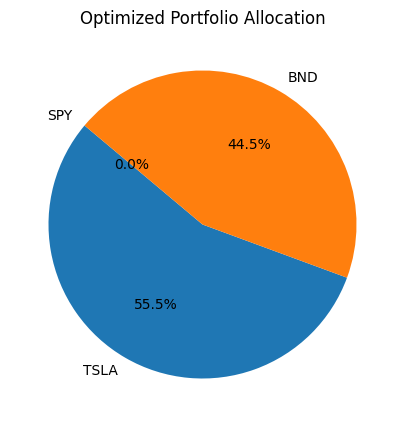

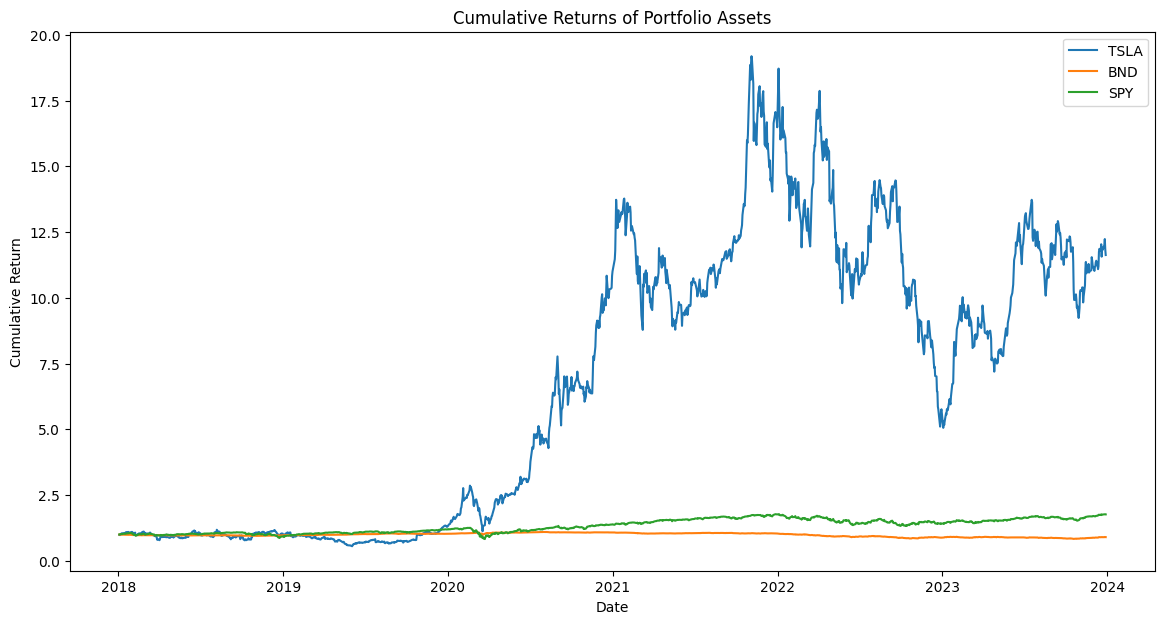

In [1]:
# portfolio_analysis.ipynb

# Import required libraries
import pandas as pd
import numpy as np
import yfinance as yf
import os
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Set the path to the data directory
data_dir = 'C:/Users/user/Desktop/Github/Portfolio_TimeseriesForcasting/notebooks/data'
weights_file = f'{data_dir}/optimized_portfolio_weights.csv'

# Ensure the data directory exists (in case the portfolio optimization script has not been run yet)
os.makedirs(data_dir, exist_ok=True)

# Load historical data for TSLA, BND, SPY (or use your actual data source)
assets = ['TSLA', 'BND', 'SPY']
data = yf.download(assets, start='2018-01-01', end='2024-01-01')['Close']

# Forecasted data: Replace with actual forecast logic or load forecast data
forecasted_data = data.tail(30)

# Calculate daily returns
daily_returns = forecasted_data.pct_change().dropna()

# Compute average annual return
annual_returns = daily_returns.mean() * 252  # Assuming 252 trading days per year

# Compute covariance matrix
cov_matrix = daily_returns.cov() * 252  # Annualized covariance

# Portfolio optimization functions
def portfolio_performance(weights, returns, cov_matrix):
    portfolio_return = np.dot(weights, returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = portfolio_return / portfolio_volatility
    return portfolio_return, portfolio_volatility, sharpe_ratio

def negative_sharpe_ratio(weights, returns, cov_matrix):
    return -portfolio_performance(weights, returns, cov_matrix)[2]

# Constraints and bounds
num_assets = len(assets)
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # Sum of weights must be 1
bounds = tuple((0, 1) for asset in range(num_assets))  # Weights between 0 and 1

# Initial guess for weights
initial_weights = num_assets * [1. / num_assets]

# Optimize portfolio for maximum Sharpe ratio
optimized = minimize(negative_sharpe_ratio, initial_weights, args=(annual_returns, cov_matrix),
                     method='SLSQP', bounds=bounds, constraints=constraints)

optimal_weights = optimized.x

# Calculate performance of the optimized portfolio
opt_return, opt_volatility, opt_sharpe = portfolio_performance(optimal_weights, annual_returns, cov_matrix)

# Save results to CSV in the specified path
results_df = pd.DataFrame({
    'Asset': assets,
    'Weight': optimal_weights
})
results_df_path = os.path.join(data_dir, 'optimized_portfolio_weights.csv')
results_df.to_csv(results_df_path, index=False)
print(f"Portfolio weights saved to {results_df_path}")

# Load the optimized portfolio weights (after saving)
weights_df = pd.read_csv(weights_file)

# Display the optimized portfolio weights
print("Optimized Portfolio Weights:")
display(weights_df)

# Visualize the allocation of the optimized portfolio
plt.figure(figsize=(8, 5))
plt.pie(weights_df['Weight'], labels=weights_df['Asset'], autopct='%1.1f%%', startangle=140)
plt.title('Optimized Portfolio Allocation')
plt.show()

# Load historical data to visualize cumulative return
historical_data = data  # You can replace this with actual historical data file if necessary
cumulative_returns = (1 + historical_data.pct_change()).cumprod()

# Plot cumulative returns
plt.figure(figsize=(14, 7))
for asset in weights_df['Asset']:
    plt.plot(cumulative_returns.index, cumulative_returns[asset], label=asset)

plt.title('Cumulative Returns of Portfolio Assets')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()

# Optional: Analyze portfolio risk and return (Value-at-Risk, etc.) if needed
# This can include risk measures such as VaR, Conditional VaR, etc.
# Add any additional analysis as necessary.
